In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [130]:
data= pd.read_csv("C:/Users/NITRO 5/OneDrive/Desktop/ds/heart_disease_uci.csv")

In [132]:
featuresBefore = [
    "age","sex","cp","trestbps","chol","fbs","restecg","thalch",
    "exang","oldpeak","slope","dataset","num"
]

#this line makes sure we only keep feature names that actually exist in the dataset so the code doesnt get ruined
featuresBefore = [c for c in featuresBefore if c in data.columns]

#its a function that checks each data type for the columns
def to_type(x):
    return "Numeric" if pd.api.types.is_numeric_dtype(x) else "Categorical"

#printing table to see how my dataset looks like
table1 = pd.DataFrame({
    "Feature": featuresBefore,
    "Type": [to_type(data[c]) for c in featuresBefore],
    "Missing (%)": [round(data[c].isna().mean() * 100, 1) for c in featuresBefore],
    "Unique": [data[c].nunique(dropna=True) for c in featuresBefore],
    "Example": [data[c].dropna().iloc[0] if data[c].notna().any() else np.nan for c in featuresBefore]
})

In [134]:
table1

,Feature,Type,Missing (%),Unique,Example
0,age,Numeric,0.0,50,63
1,sex,Categorical,0.0,2,Male
2,cp,Categorical,0.0,4,typical angina
3,trestbps,Numeric,6.4,61,145.0
4,chol,Numeric,3.3,217,233.0
5,fbs,Categorical,9.8,2,True
6,restecg,Categorical,0.2,3,lv hypertrophy
7,thalch,Numeric,6.0,119,150.0
8,exang,Categorical,6.0,2,False
9,oldpeak,Numeric,6.7,53,2.3


In [136]:
#caluclating missing values in percentage and its only the first 10 
missing_values = (data.isna().mean() * 100).round(1).sort_values(ascending=False)
table3 = missing_values[missing_values > 0].head(10).reset_index()
table3.columns = ["Column", "Missing (%)"]

In [138]:
table3

,Column,Missing (%)
0,ca,66.4
1,thal,52.8
2,slope,33.6
3,fbs,9.8
4,oldpeak,6.7
5,trestbps,6.4
6,exang,6.0
7,thalch,6.0
8,chol,3.3
9,restecg,0.2


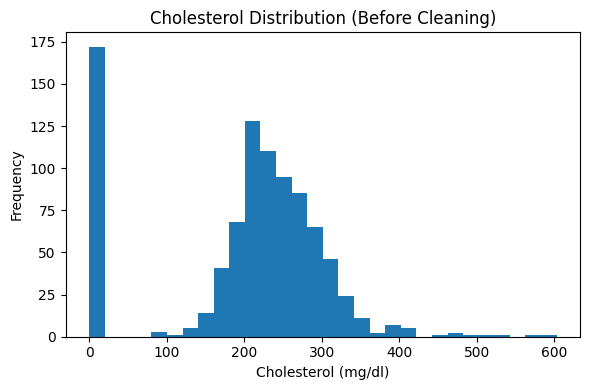

In [140]:
#plot histogram to visualize cholesterol distribution before cleaning
plt.figure(figsize=(6,4))
plt.hist(data["chol"], bins=30)
plt.xlabel("Cholesterol (mg/dl)")
plt.ylabel("Frequency")
plt.title("Cholesterol Distribution (Before Cleaning)")
plt.tight_layout()
plt.show()

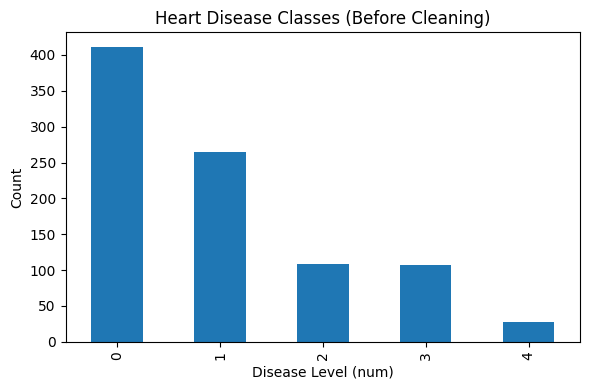

In [142]:
# plot histogram to visualize heart disease classes before cleaning
plt.figure(figsize=(6,4))
data["num"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Disease Level (num)")
plt.ylabel("Count")
plt.title("Heart Disease Classes (Before Cleaning)")
plt.tight_layout()
plt.show()

In [144]:
#cleaning the dataset

#remove duplicated patient records ignoring the id column
df = data.drop_duplicates(subset=[c for c in data.columns if c != "id"])
df = df.drop(columns=["id"])

#no cholesterol level is zero so we treate it as null normal value is 120–200 mg/dl
df.loc[df["chol"] == 0, "chol"] = np.nan
#no resting blood pressure level is zero so we treate it as null normal value is 90–140 mm Hg
df.loc[df["trestbps"] == 0, "trestbps"] = np.nan

#we stored fasting blood pressure in Int64 instead of normal int so we store null values in it
df["fbs"] = df["fbs"].map({True:1, False:0}).astype("Int64")
#we stored exercise induced angina in Int64 instead of normal int so we store null values in it
df["exang"] = df["exang"].map({True:1, False:0}).astype("Int64")

#num is the original diagnosis label in the UCI Heart Disease dataset
df["target"] = (df["num"] > 0).astype(int)
#we drop num (label) so we dont cause data leackage and model doesnt see the answers
df = df.drop(columns=["num"])

#remove any column where more than 40% of the values are missing
df = df.drop(columns=df.isna().mean()[df.isna().mean() > 0.40].index)

#selecting numeric columns without target (label) then filling missing data using median
numOfcols = df.select_dtypes(include=["number", "Int64"]).columns.drop("target")
df[numOfcols] = df[numOfcols].fillna(df[numOfcols].median())

#get all columns that contain text categories and filling missing data using mode
categories = df.select_dtypes(include=["object"]).columns
for c in categories:
    df[c] = df[c].fillna(df[c].mode()[0])

#we used dummies to convert textual data into numrical because we cant train a model with textual data
encodeData = pd.get_dummies(df, drop_first=True)

In [146]:
encodeData

,age,trestbps,chol,fbs,thalch,exang,oldpeak,target,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_normal,restecg_st-t abnormality,slope_flat,slope_upsloping
0,63,145.0,233.0,1,150.0,0,2.3,0,True,False,False,False,False,False,True,False,False,False,False
1,67,160.0,286.0,0,108.0,1,1.5,1,True,False,False,False,False,False,False,False,False,True,False
2,67,120.0,229.0,0,129.0,1,2.6,1,True,False,False,False,False,False,False,False,False,True,False
3,37,130.0,250.0,0,187.0,0,3.5,0,True,False,False,False,False,True,False,True,False,False,False
4,41,130.0,204.0,0,172.0,0,1.4,0,False,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,127.0,333.0,1,154.0,0,0.0,1,False,False,False,True,False,False,False,False,True,True,False
916,62,130.0,139.0,0,140.0,0,0.5,0,True,False,False,True,False,False,True,False,True,True,False
917,55,122.0,223.0,1,100.0,0,0.0,1,True,False,False,True,False,False,False,False,True,True,False
918,58,130.0,385.0,1,140.0,0,0.5,0,True,False,False,True,False,False,False,False,False,True,False


In [148]:
#printing the values after cleaning and visualization
missing_after = df.isna().sum()
print(missing_after)

age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
target      0
dtype: int64


In [150]:
#we created this table to show what feature actually means
table2 = pd.DataFrame([
    ["age", "Patient age", "Integer years."],
    ["sex", "Patient gender", "Male / Female."],
    ["dataset", "Data source hospital", "Cleveland, Hungary, Switzerland, VA Long Beach."],
    ["cp", "Chest pain type", "typical, atypical, non-anginal, asymptomatic."],
    ["trestbps", "Resting blood pressure", "mm Hg. We treat 0 as missing."],
    ["chol", "Serum cholesterol", "mg/dl. We treat 0 as missing."],
    ["fbs", "Fasting blood sugar", "Converted to 0/1 (False/True)."],
    ["restecg", "Resting ECG results", "Categorical (example: normal)."],
    ["thalch", "Max heart rate achieved", "Numeric."],
    ["exang", "Exercise induced angina", "Converted to 0/1."],
    ["oldpeak", "ST depression induced by exercise", "Numeric."],
    ["slope", "Slope of peak exercise ST segment", "upsloping / flat / downsloping."],
    ["target", "Heart disease label", "0 = No disease, 1 = Disease (from num)."]
], columns=["Feature", "What it means", "Values"])

In [152]:
table2

,Feature,What it means,Values
0,age,Patient age,Integer years.
1,sex,Patient gender,Male / Female.
2,dataset,Data source hospital,"Cleveland, Hungary, Switzerland, VA Long Beach."
3,cp,Chest pain type,"typical, atypical, non-anginal, asymptomatic."
4,trestbps,Resting blood pressure,mm Hg. We treat 0 as missing.
5,chol,Serum cholesterol,mg/dl. We treat 0 as missing.
6,fbs,Fasting blood sugar,Converted to 0/1 (False/True).
7,restecg,Resting ECG results,Categorical (example: normal).
8,thalch,Max heart rate achieved,Numeric.
9,exang,Exercise induced angina,Converted to 0/1.


In [154]:
#calculating mean std dev min max after cleaning
main_num = [c for c in ["age","trestbps","chol","thalch","oldpeak"] if c in df.columns]
desc = df[main_num].agg(["mean","std","min","max"]).T
desc = desc.rename(columns={"mean":"Mean","std":"Std Dev.","min":"Min","max":"Max"}).reset_index()
desc = desc.rename(columns={"index":"Feature"})

In [156]:
desc

,Feature,Mean,Std Dev.,Min,Max
0,age,53.510893,9.432617,28.0,77.0
1,trestbps,132.141612,17.924706,80.0,200.0
2,chol,245.367102,51.822418,85.0,603.0
3,thalch,137.689542,25.153455,60.0,202.0
4,oldpeak,0.855120,1.058450,-2.6,6.2


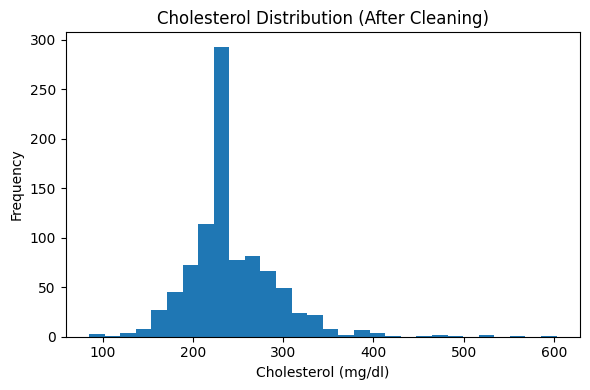

In [158]:
plt.figure(figsize=(6,4))
plt.hist(df["chol"], bins=30)
plt.xlabel("Cholesterol (mg/dl)")
plt.ylabel("Frequency")
plt.title("Cholesterol Distribution (After Cleaning)")
plt.tight_layout()
plt.show()

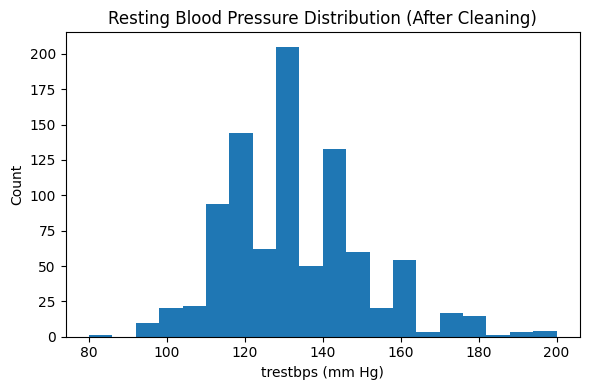

In [160]:
plt.figure(figsize=(6,4))
plt.hist(df["trestbps"], bins=20)
plt.xlabel("trestbps (mm Hg)")
plt.ylabel("Count")
plt.title("Resting Blood Pressure Distribution (After Cleaning)")
plt.tight_layout()
plt.show()

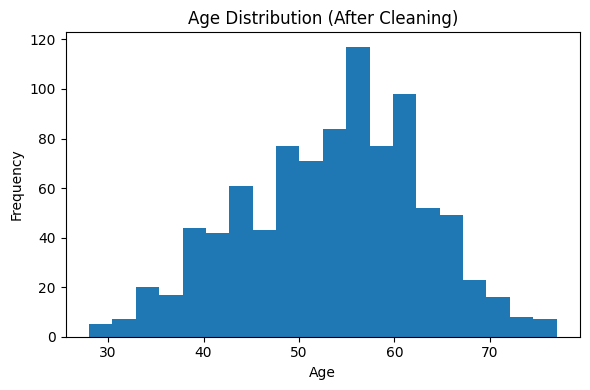

In [162]:
plt.figure(figsize=(6,4))
plt.hist(df["age"], bins=20)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution (After Cleaning)")
plt.tight_layout()
plt.show()

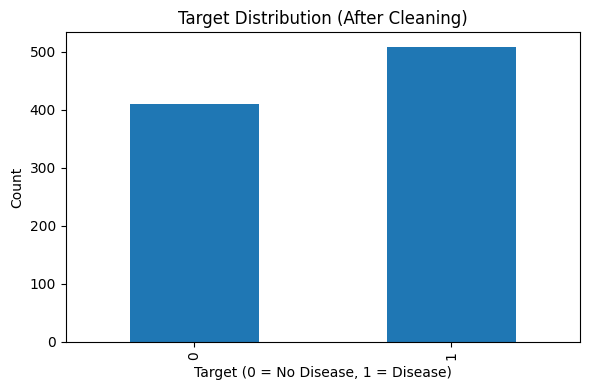

In [164]:
plt.figure(figsize=(6,4))
df["target"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Target (0 = No Disease, 1 = Disease)")
plt.ylabel("Count")
plt.title("Target Distribution (After Cleaning)")
plt.tight_layout()
plt.show()

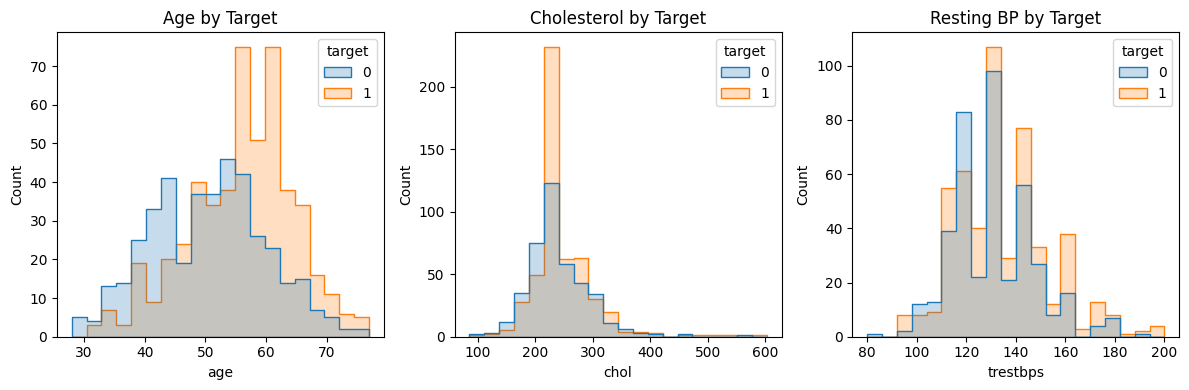

In [166]:
# list of numerical features to compare by target
cols3 = [("age","Age"), ("chol","Cholesterol"), ("trestbps","Resting BP")]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, (col, label) in zip(axes, cols3):
    if col in df.columns:
        sns.histplot(data=df, x=col, hue="target", bins=20, element="step", kde=False, ax=ax)
        ax.set_title(f"{label} by Target")
    else:
        ax.axis("off")
plt.tight_layout()

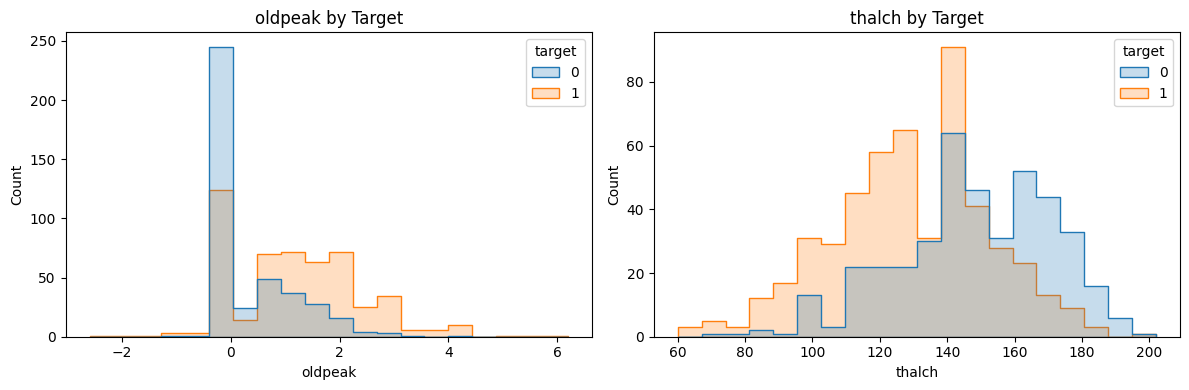

In [167]:
# compare feature distribution between disease and no disease classes
cols2 = [("oldpeak","oldpeak"), ("thalch","thalch")]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (col, label) in zip(axes, cols2):
    if col in df.columns:
        sns.histplot(data=df, x=col, hue="target", bins=20, element="step", kde=False, ax=ax)
        ax.set_title(f"{label} by Target")
    else:
        ax.axis("off")
plt.tight_layout()

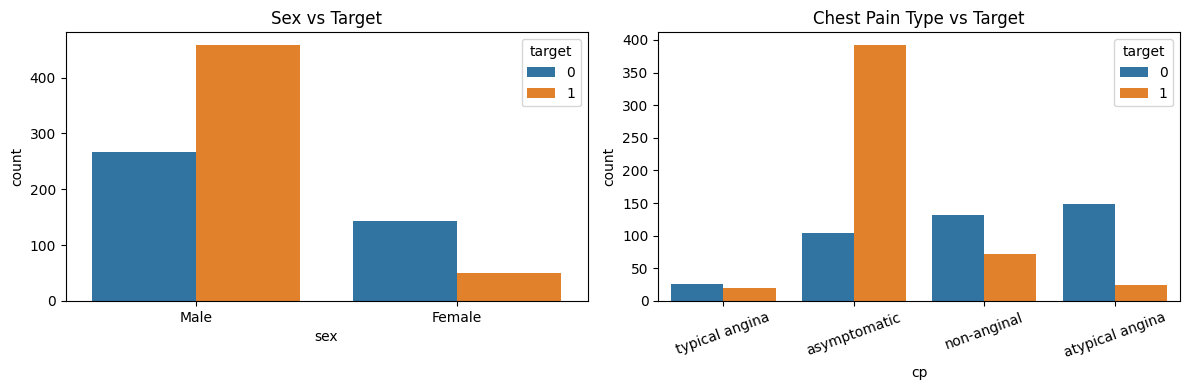

In [170]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if "sex" in df.columns:
    sns.countplot(data=df, x="sex", hue="target", ax=axes[0])
    axes[0].set_title("Sex vs Target")
else:
    axes[0].axis("off")

if "cp" in df.columns:
    sns.countplot(data=df, x="cp", hue="target", ax=axes[1])
    axes[1].set_title("Chest Pain Type vs Target")
    axes[1].tick_params(axis="x", rotation=20)
else:
    axes[1].axis("off")

plt.tight_layout()

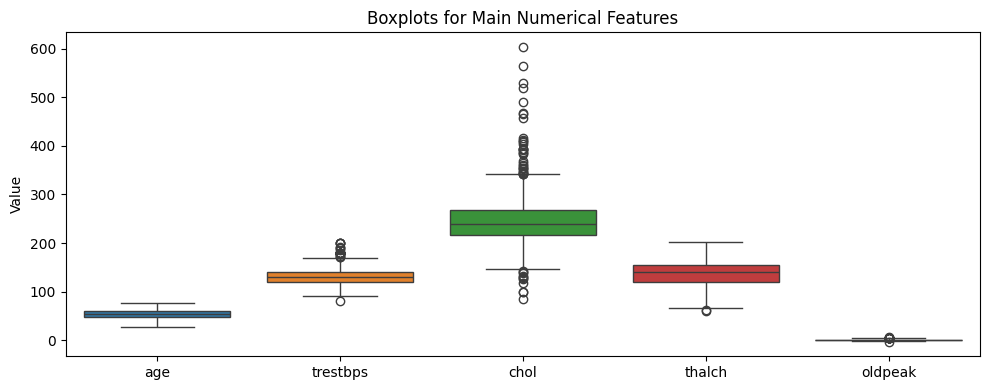

In [172]:
#we visualized outliers using boxplots
if main_num:
    plt.figure(figsize=(10,4))
    sns.boxplot(data=df[main_num])
    plt.title("Boxplots for Main Numerical Features")
    plt.ylabel("Value")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

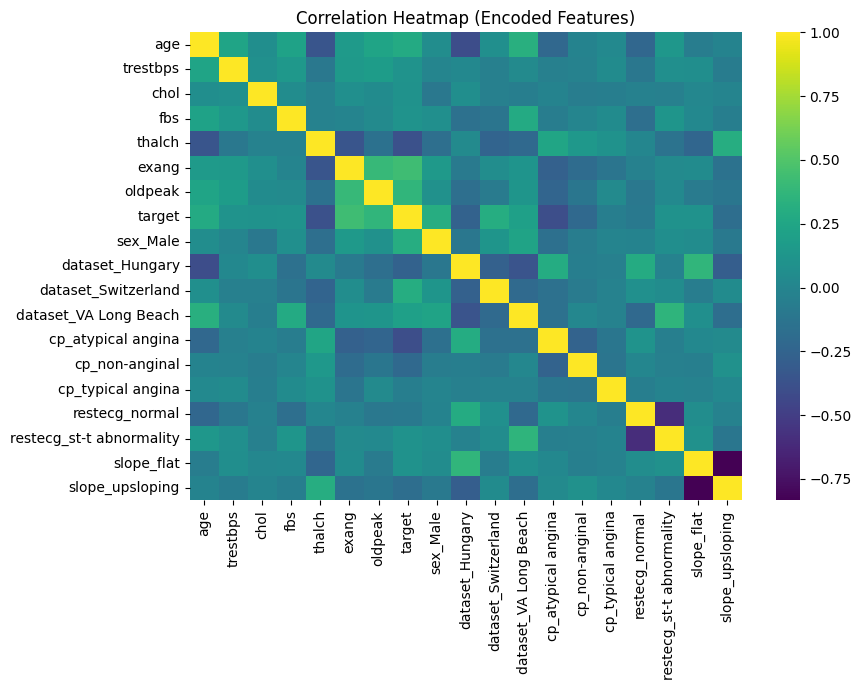

In [174]:
#we visualized correlations using a heatmap
plt.figure(figsize=(9,7))
corr = encodeData.corr(numeric_only=True)
sns.heatmap(corr, cmap="viridis", cbar=True)
plt.title("Correlation Heatmap (Encoded Features)")
plt.tight_layout()
plt.show()

In [175]:
X = encodeData.drop("target", axis=1)
y = encodeData["target"]

In [178]:
#machine learning part

In [180]:
from sklearn.model_selection import train_test_split

#we split the dataset 80% training and 20%testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)

Train size: (734, 18)
Test size : (184, 18)


In [182]:
#using different ml algorithims to predict if there is heart disease or no

In [184]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

In [186]:
#cross validation is used to see how the data will do on unseen data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [188]:
#define the evaluation metrics used to assess the model performance
score = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

In [190]:
#we are using the dummy classifier as our first model to show at the end if our model is useful or no
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
y_prob_dummy = dummy.predict_proba(X_test)[:, 1]

print("Dummy Classifier Results")
print("Accuracy :", accuracy_score(y_test, y_pred_dummy))
print("Precision:", precision_score(y_test, y_pred_dummy, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_dummy, zero_division=0))
print("F1-score :", f1_score(y_test, y_pred_dummy, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_dummy))

Dummy Classifier Results
Accuracy : 0.5543478260869565
Precision: 0.5543478260869565
Recall   : 1.0
F1-score : 0.7132867132867133
ROC-AUC  : 0.5


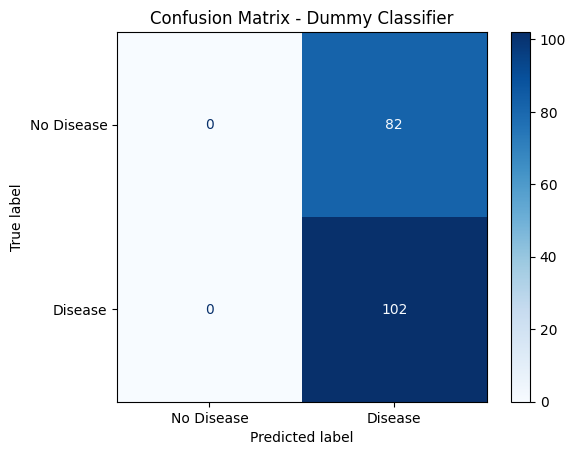

In [192]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_dummy,
    display_labels=["No Disease", "Disease"],
    cmap="Blues"
)

plt.title("Confusion Matrix - Dummy Classifier")
plt.show()

In [194]:
#logistic regression used for classification to know if there is heart disease or no and it works better on similar scales

lr_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000, random_state=42))
])

lr_grid_params = {
    "lr__C": [0.01, 0.1, 1, 10, 100], #controls regularization strength
    "lr__class_weight": [None, "balanced"], #helps if the dataset is imbalanced
    "lr__penalty": ["l2"], #common stable setup
    "lr__solver": ["lbfgs"]
}

lr_gridsearch = GridSearchCV(
    estimator=lr_model,
    param_grid=lr_grid_params,
    scoring=score,      
    refit="roc_auc",    
    cv=cv,
    n_jobs=-1
)

lr_gridsearch.fit(X_train, y_train)

lr_best = lr_gridsearch.best_estimator_

print("Best Logistic Regression Parameters:")
print(lr_gridsearch.best_params_)

print("Best CV ROC-AUC Score:")
print(lr_gridsearch.best_score_)

Best Logistic Regression Parameters:
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
Best CV ROC-AUC Score:
0.8855347021742686


In [196]:
y_pred_lr = lr_best.predict(X_test)
y_prob_lr = lr_best.predict_proba(X_test)[:, 1]

print("Logistic Regression Results")
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_lr, zero_division=0))
print("F1-score :", f1_score(y_test, y_pred_lr, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_lr))

Logistic Regression Results
Accuracy : 0.8478260869565217
Precision: 0.8303571428571429
Recall   : 0.9117647058823529
F1-score : 0.8691588785046729
ROC-AUC  : 0.9304160688665709


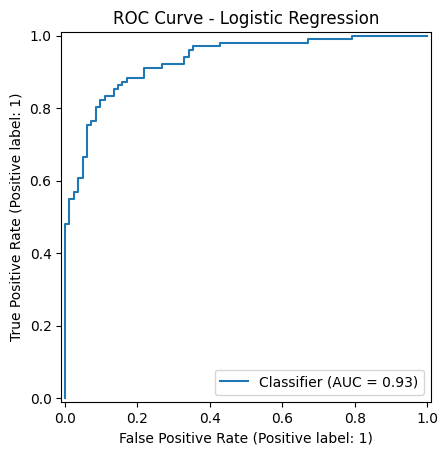

In [198]:
RocCurveDisplay.from_predictions(y_test, y_prob_lr)
plt.title("ROC Curve - Logistic Regression")
plt.show()

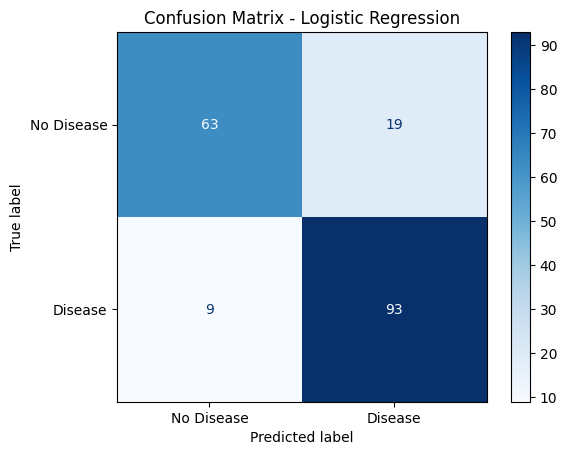

In [200]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_lr,                         
    display_labels=["No Disease", "Disease"],
    cmap="Blues"
)

plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [209]:
#random forest is a non linear model that uses many decision trees and combines their results to improve performance

rf_model = RandomForestClassifier(random_state=42)

rf_grid_params = {
    "n_estimators": [200, 500], #number of trees
    "max_depth": [None, 5, 10, 20], #tree depth
    "min_samples_split": [2, 5, 10], #minimum samples to split
    "min_samples_leaf": [1, 2, 4], #minimum samples in leaf
    "class_weight": [None, "balanced"] #handle class imbalance
}

rf_gridsearch = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_grid_params,
    scoring=score,        #
    refit="roc_auc",      
    cv=cv,
    n_jobs=-1
)

rf_gridsearch.fit(X_train, y_train)

rf_best = rf_gridsearch.best_estimator_

print("Best Random Forest Parameters:")
print(rf_gridsearch.best_params_)

print("Best CV ROC-AUC Score:")
print(rf_gridsearch.best_score_)

Best Random Forest Parameters:
{'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Best CV ROC-AUC Score:
0.8752206099631575


In [211]:
y_pred_rf = rf_best.predict(X_test)
y_prob_rf = rf_best.predict_proba(X_test)[:, 1]

print("Random Forest Results")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_rf, zero_division=0))
print("F1-score :", f1_score(y_test, y_pred_rf, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_rf))

Random Forest Results
Accuracy : 0.8369565217391305
Precision: 0.8272727272727273
Recall   : 0.8921568627450981
F1-score : 0.8584905660377359
ROC-AUC  : 0.9116451458632233


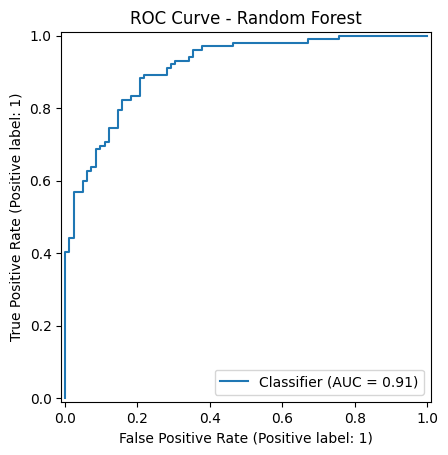

In [213]:
RocCurveDisplay.from_predictions(y_test, y_prob_rf)
plt.title("ROC Curve - Random Forest")
plt.show()

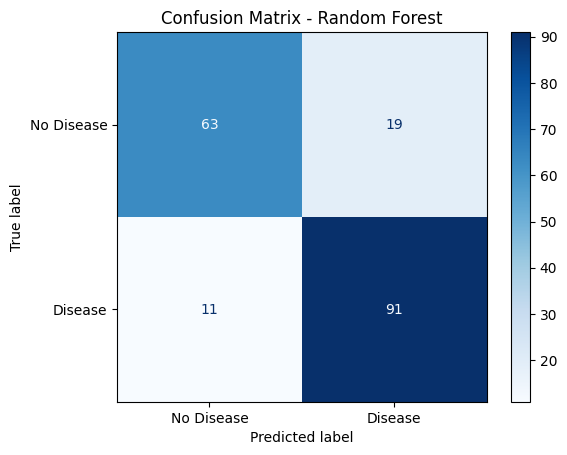

In [215]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_rf,
    display_labels=["No Disease", "Disease"],
    cmap="Blues"
)

plt.title("Confusion Matrix - Random Forest")
plt.show()

In [217]:
#svm used as a non linear classifier to separate patients with and without heart disease

svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True, random_state=42))
])

svm_grid_params = {
    "svm__kernel": ["rbf"],
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": ["scale", 0.01, 0.1, 1],
    "svm__class_weight": [None, "balanced"]
}

svm_gridsearch = GridSearchCV(
    estimator=svm_model,
    param_grid=svm_grid_params,
    scoring=score,      
    refit="roc_auc",    
    cv=cv,
    n_jobs=-1
)

svm_gridsearch.fit(X_train, y_train)

svm_best = svm_gridsearch.best_estimator_

print("Best SVM Parameters:")
print(svm_gridsearch.best_params_)

print("Best CV ROC-AUC Score:")
print(svm_gridsearch.best_score_)

Best SVM Parameters:
{'svm__C': 1, 'svm__class_weight': 'balanced', 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best CV ROC-AUC Score:
0.8842110073004381


In [219]:
y_pred_svm = svm_best.predict(X_test)
y_prob_svm = svm_best.predict_proba(X_test)[:, 1]

print("SVM Results")
print("Accuracy :", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_svm, zero_division=0))
print("F1-score :", f1_score(y_test, y_pred_svm, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_svm))


SVM Results
Accuracy : 0.8586956521739131
Precision: 0.8454545454545455
Recall   : 0.9117647058823529
F1-score : 0.8773584905660378
ROC-AUC  : 0.9319703491152559


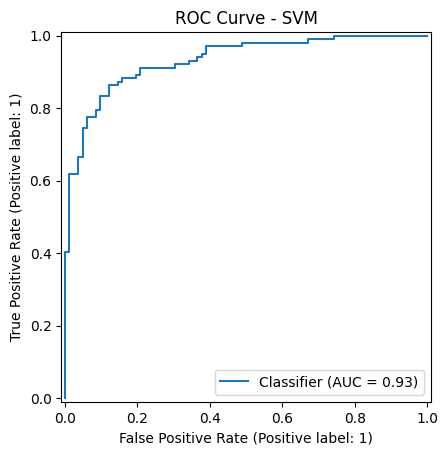

In [221]:
RocCurveDisplay.from_predictions(y_test, y_prob_svm)
plt.title("ROC Curve - SVM")
plt.show()

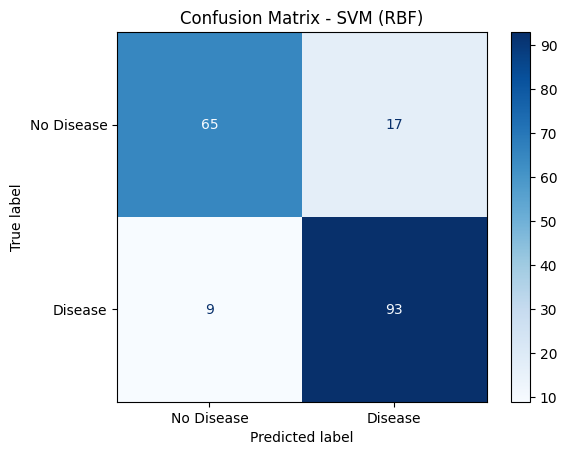

In [223]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_svm,
    display_labels=["No Disease", "Disease"],
    cmap="Blues"
)

plt.title("Confusion Matrix - SVM (RBF)")
plt.show()